# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [158]:
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [159]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [160]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [161]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [162]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [163]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [164]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [165]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [166]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [167]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [168]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [169]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [170]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [171]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [172]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [173]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Why is this $[...] when the same product is available for $[...] here? />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I'm sorry; b

In [174]:
# https://stackoverflow.com/a/47091490/4084039


def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [175]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [176]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [177]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [178]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [179]:
# Combining all the above stundents 
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:02<00:00, 2054.00it/s]


In [180]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [181]:
## Similartly you can do preprocessing for review summary also.
#Sorting data according to Time in ascending order for Time Based Splitting
data = final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')


# Collecting 120k rows without repetition from time_sorted_data dataframe
my_final = data.take(np.random.permutation(len(final))[:120000])
#print(my_final.shape)
# To get 2k +ve and 2k -ve reviews randomly.
#data_pos = data[data["Score"] == 1].sample(n = 200)
#data_neg = data[data["Score"] == 0].sample(n = 200)
#my_final = pd.concat([data_pos, data_neg])

#x = my_final['CleanedText'].values

In [182]:
from sklearn.model_selection import train_test_split
x = my_final['Text'].values
y = my_final['Score']

In [183]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

# [4] Featurization

## [4.1] BAG OF WORDS

In [184]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
#count_vect.fit(my_final)
#print("some feature names ", count_vect.get_feature_names()[:10])
#print('='*50)

#final_counts = count_vect.transform(my_final)
#print("the type of count vectorizer ",type(final_counts))
#print("the shape of out text BOW vectorizer ",final_counts.get_shape())
#print("the number of unique words ", final_counts.get_shape()[1])


X_train    = count_vect.fit_transform(X_train)
X_cv       = count_vect.transform(X_cv)
X_test     = count_vect.transform(X_test)

### Applying Logistic Regression with L1 regularization on BOW, SET 1

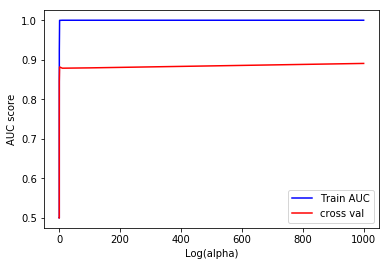

In [185]:
c_values = []
alpha        = 0.0001
while(alpha <= 1000):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = LogisticRegression(penalty='l1', C=C, n_jobs=-1,class_weight = 'balanced')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('Log(alpha)')
plt.show()





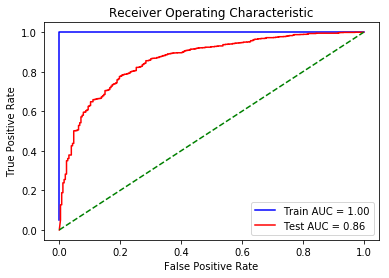

In [186]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [187]:
optimal_model = LogisticRegression(penalty='l1', C=C,class_weight = 'balanced')
optimal_model.fit(X_train, y_train)
prediction = optimal_model.predict(X_test)

In [188]:
bow_features = count_vect.get_feature_names()
log_prob = optimal_model.coef_
feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
#feature_prob_tr.shape

In [189]:
from sklearn.metrics import classification_report
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

             precision    recall  f1-score   support

          0       0.59      0.51      0.54       253
          1       0.90      0.93      0.91      1243

avg / total       0.85      0.86      0.85      1496



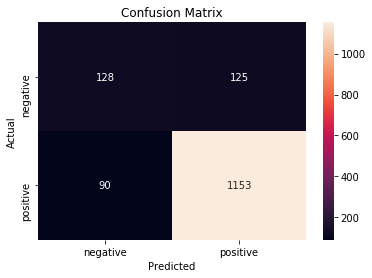

In [190]:
import seaborn as sb
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Calculating sparsity on weight vector obtained using L1 regularization on BOW, SET 1

In [191]:
# With lambda = 1
clf = LogisticRegression(C=1, penalty='l1',n_jobs=-1,class_weight = 'balanced');
clf.fit(X_train, y_train);
w = clf.coef_
print(np.count_nonzero(w))

490


In [192]:
# With lambda = 10
clf = LogisticRegression(C=0.1, penalty='l1',n_jobs=-1,class_weight = 'balanced');
clf.fit(X_train, y_train);
w = clf.coef_
print(np.count_nonzero(w))

128


In [193]:
# With lambda = 100
clf = LogisticRegression(C=0.01, penalty='l1',n_jobs=-1,class_weight = 'balanced');
clf.fit(X_train, y_train);
w = clf.coef_
print(np.count_nonzero(w))

9


### Applying Logistic Regression with L2 regularization on BOW, SET 1

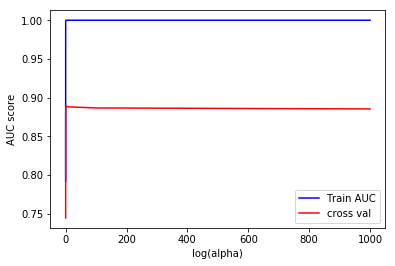

In [194]:
c_values = []
alpha        = 0.0001
while(alpha <= 1000):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = LogisticRegression(penalty='l2', C=C, n_jobs=-1,class_weight = 'balanced')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('log(alpha)')
plt.show()





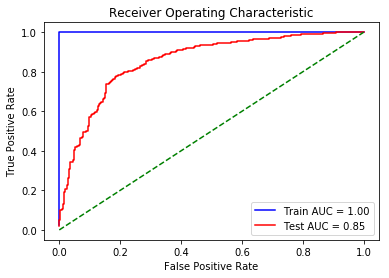

In [195]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [196]:
optimal_model = LogisticRegression(penalty='l2', C=C,class_weight = 'balanced')
optimal_model.fit(X_train, y_train)
prediction = optimal_model.predict(X_test)

In [197]:
bow_features = count_vect.get_feature_names()
feat_count = optimal_model.classes_ 
#feat_count.shape

In [198]:
log_prob = optimal_model.coef_
feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
feature_prob_tr.shape

(9437, 1)

In [199]:
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

             precision    recall  f1-score   support

          0       0.62      0.54      0.57       253
          1       0.91      0.93      0.92      1243

avg / total       0.86      0.86      0.86      1496



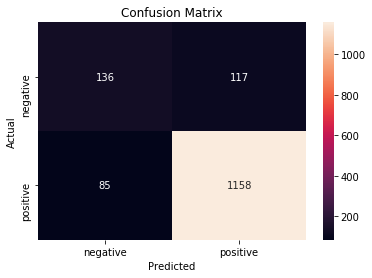

In [200]:
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Performing pertubation test (multicollinearity check) on BOW, SET 1

In [201]:
import scipy as sp
from scipy.sparse import csr_matrix

e = sp.stats.distributions.norm.rvs(loc=0,scale=0.00001)
# Vector before the addition of epsilon
W_before_e = model.coef_

# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train.count_nonzero()


# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train.indices
indptr_X_train = X_train.indptr

# Creating a list of same element with repetition
data = [e] * no_of_non_zero
Shape = X_train.shape

# Creating sparse matrix
sparse_e = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

# Add sparse_epsilon and X-train_vec_standardized to get a new sparse matrix with epsilon added to each 
# non-zero element of X_train_vec_standardized
e_train = X_train + sparse_e


In [202]:
# training Logistic Regression Classifier with epsilon_train
import warnings
warnings.filterwarnings("ignore")

e_lr = LogisticRegression(penalty='l2', C=C, n_jobs=-1,class_weight = 'balanced')
e_lr.fit(e_train,y_train)

# Vector after the addition of epsilon
W_after_e = e_lr.coef_
change_vector = W_after_e - W_before_e
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]

#kk = sorted_change_vector[0,0:20]

0 th percentile :  2.2301174568758065e-08
10 th percentile :  1.3372962122957198e-05
20 th percentile :  6.112188646517137e-05
30 th percentile :  0.0003442605198210781
40 th percentile :  0.0007258507593051744
50 th percentile :  0.0013092296698015704
60 th percentile :  0.002041822198636245
70 th percentile :  0.0030751345863336277
80 th percentile :  0.004827736345497862
90 th percentile :  0.008376605339656984
100 th percentile :  0.1394704185449568


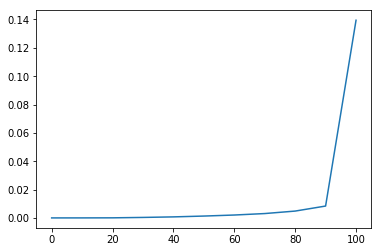

In [203]:
k = range(0,101,10)
for i in k:
    print(i, "th percentile : ",np.percentile(sorted_change_vector,i))

plt.plot(k,np.percentile(sorted_change_vector,k) )

In [228]:
indices = W_after_e.argsort()[::-1][:20]
print(np.take(count_vect.get_feature_names(),indices))

[['disappointing' 'complained' 'weak' ... 'love' 'nice' 'great']]


### Feature Importance on BOW, SET 1

In [204]:
# To show top 10 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = True)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 disappointing   -4.835986
complained      -4.662764
weak            -4.330772
poisoning       -3.970248
awful           -3.940713
cancelled       -3.728245
return          -3.641893
watery          -3.586441
finish          -3.531555
popped          -3.529419
Name: 0, dtype: float64


 Top 10 Positive Features:-
 great         3.982286
nice          3.825907
love          3.645404
ordering      3.385291
perfect       3.381437
favorite      3.356619
excellent     3.182021
peppermint    3.063564
best          3.021953
good          3.005549
Name: 0, dtype: float64


## [4.3] TF-IDF

In [205]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [206]:
# Initializing tfidf vectorizer
tfidf_vect = TfidfVectorizer(ngram_range=(1, 2), min_df=10)

# Fitting for tfidf vectorization
X_train = tfidf_vect.fit_transform(X_train)
X_cv = tfidf_vect.transform(X_cv)
X_test = tfidf_vect.transform(X_test)


#print("the type of count vectorizer ",type(final_tf_idf))
#print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
#print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

### Applying Logistic Regression with L1 regularization on TFIDF, SET 2

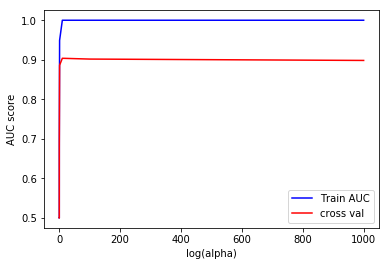

In [207]:
c_values = []
alpha        = 0.0001
while(alpha <= 1000):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = LogisticRegression(penalty='l1', C=C, n_jobs=-1,class_weight = 'balanced')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('log(alpha)')
plt.show()

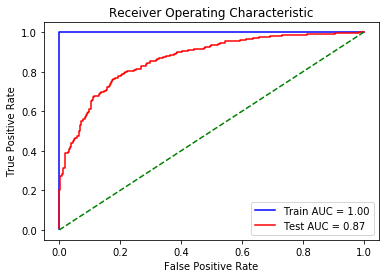

In [208]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [209]:
optimal_model = LogisticRegression(penalty='l1',C=1,class_weight = 'balanced')
optimal_model.fit(X_train, y_train)
prediction = optimal_model.predict(X_test)

In [210]:
bow_features = tfidf_vect.get_feature_names()
log_prob = optimal_model.coef_
feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
#feature_prob_tr.shape

In [211]:
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

             precision    recall  f1-score   support

          0       0.48      0.72      0.58       253
          1       0.94      0.84      0.89      1243

avg / total       0.86      0.82      0.83      1496



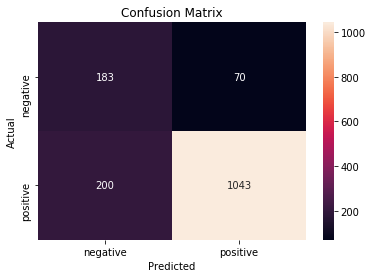

In [212]:
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Calculating sparsity on weight vector obtained using L1 regularization on TF-IDF, SET 2

In [213]:
# With lambda = 1
clf = LogisticRegression(C=1, penalty='l1',n_jobs=-1,class_weight = 'balanced');
clf.fit(X_train, y_train);
w = clf.coef_
print(np.count_nonzero(w))

164


In [214]:
# With lambda = 10
clf = LogisticRegression(C=0.1, penalty='l1',n_jobs=-1,class_weight = 'balanced');
clf.fit(X_train, y_train);
w = clf.coef_
print(np.count_nonzero(w))

2


In [215]:
# With lambda = 100
clf = LogisticRegression(C=0.01, penalty='l1',n_jobs=-1,class_weight = 'balanced');
clf.fit(X_train, y_train);
w = clf.coef_
print(np.count_nonzero(w))

0


### Applying Logistic Regression with L2 regularization on TFIDF, SET 2

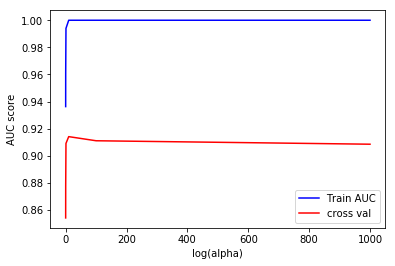

In [216]:
c_values = []
alpha        = 0.0001
while(alpha <= 1000):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = LogisticRegression(penalty='l2', C=C, n_jobs=-1,class_weight = 'balanced')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('log(alpha)')
plt.show()





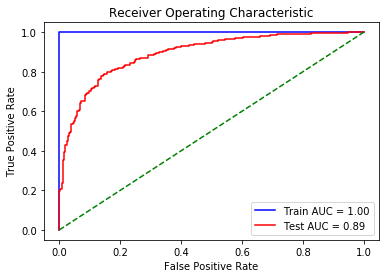

In [217]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [218]:
optimal_model = LogisticRegression(penalty='l2',C=C,class_weight = 'balanced')
optimal_model.fit(X_train, y_train)
prediction = optimal_model.predict(X_test)

In [219]:
bow_features = tfidf_vect.get_feature_names()
log_prob = optimal_model.coef_
feature_prob = pd.DataFrame(log_prob, columns = bow_features)
feature_prob_tr = feature_prob.T
#feature_prob_tr.shape

In [220]:
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

             precision    recall  f1-score   support

          0       0.65      0.54      0.59       253
          1       0.91      0.94      0.93      1243

avg / total       0.87      0.87      0.87      1496



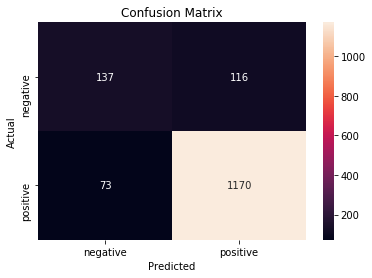

In [221]:
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Performing pertubation test (multicollinearity check) on TF-IDF, SET 2

In [222]:
e = sp.stats.distributions.norm.rvs(loc=0,scale=0.00001)
# Vector before the addition of epsilon
W_before_e = model.coef_

# Number of non zero elements in X_train_vec_standardized sparse matrix
no_of_non_zero = X_train.count_nonzero()


# Creating new sparse matrix with epsilon at same position of non-zero elements of X_train_vec_standardized
indices_X_train = X_train.indices
indptr_X_train = X_train.indptr

# Creating a list of same element with repetition
data = [e] * no_of_non_zero
Shape = X_train.shape

# Creating sparse matrix
sparse_e = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)

e_train = X_train + sparse_e


In [223]:
e = sp.stats.distributions.norm.rvs(loc=0,scale=0.00001)
w = model.coef_
no_of_non_zero = X_train.count_nonzero()
indices_X_train = X_train.indices
indptr_X_train = X_train.indptr
data = [e] * no_of_non_zero
Shape = X_train.shape
# Creating sparse matrix
sparse_e = csr_matrix((data,indices_X_train,indptr_X_train),shape=Shape,dtype=float)
e_train = X_train + sparse_e

In [224]:
e_lr = LogisticRegression(penalty='l2', C=1, n_jobs=-1,class_weight = 'balanced')
e_lr.fit(e_train,y_train)
# Vector after the addition of epsilon
w2 = e_lr.coef_
change_vector = w2 - w
sorted_change_vector = np.sort(np.absolute(change_vector))[:,::-1]
#sorted_change_vector[0,0:20]

0 th percentile is:  0.004588377051502196
10 th percentile is:  0.34369483282285707
20 th percentile is:  0.7074421303507565
30 th percentile is:  1.1053613499137018
40 th percentile is:  1.5344558912913995
50 th percentile is:  1.9432765669630379
60 th percentile is:  2.3919168328991702
70 th percentile is:  2.94599214222873
80 th percentile is:  3.694586931818423
90 th percentile is:  4.88562374997403
100 th percentile is:  15.445157560628182


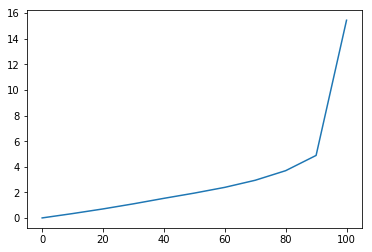

In [225]:
k = range(0,101,10)
for i in k:
    print(i, "th percentile is: ",np.percentile(sorted_change_vector,i))

plt.plot(t,np.percentile(sorted_change_vector,k) )

90 th percentile is :  4.88562374997403
91 th percentile is :  5.053295704270963
92 th percentile is :  5.271370330167627
93 th percentile is :  5.506776838877424
94 th percentile is :  5.723877566330481
95 th percentile is :  6.031275944960446
96 th percentile is :  6.421484947203925
97 th percentile is :  6.945429286772834
98 th percentile is :  7.598180291376245
99 th percentile is :  8.481780201922476
100 th percentile is :  15.445157560628182


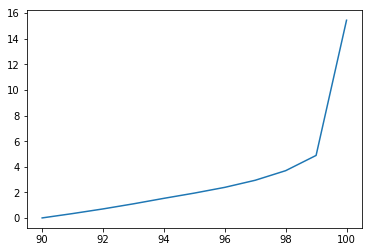

In [226]:
k = range(90,101,1)
for i in k:
    print(i, "th percentile is : ",np.percentile(sorted_change_vector,i))

plt.plot(k,np.percentile(sorted_change_vector,t) )

In [227]:
indices = W_after_e.argsort()[::-1][:20]
print(np.take(count_vect.get_feature_names(),indices))

[['disappointing' 'complained' 'weak' ... 'love' 'nice' 'great']]


### Feature Importance on TFIDF, SET 2

In [229]:
# To show top 10 feature from both class
# Feature Importance
print("Top 10 Negative Features:-\n",feature_prob_tr[0].sort_values(ascending = True)[0:10])
print("\n\n Top 10 Positive Features:-\n",feature_prob_tr[1].sort_values(ascending = False)[0:10])

Top 10 Negative Features:-
 not        -17.681280
is not     -16.404478
products   -14.080173
but will   -12.684885
popped     -12.143638
their      -12.118568
terrible   -11.913231
stick      -11.807357
plastic    -11.719342
awful      -11.460048
Name: 0, dtype: float64


 Top 10 Positive Features:-
 great        19.391828
good         14.698934
the best     14.104598
best         13.750970
love         12.956667
not bad      12.178875
always       11.592041
fast         11.103957
delicious    11.097257
love this    11.033315
Name: 0, dtype: float64


## [4.4] Word2Vec

In [230]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [231]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in X_train:
    list_of_sentance.append(sentance.split())

 # min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
#print("number of words that occured minimum 5 times ",len(w2v_words))

def avgwtv(X_test):
    '''
    returns average woed2vec
    '''
    i=0
    list_of_sentance=[]
    for sentance in X_test:
        list_of_sentance.append(sentance.split())
    test_vectors = [];
    for sent in tqdm(list_of_sentance):
        sent_vec = np.zeros(50) 
        cnt_words =0; 
        for word in sent:
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        test_vectors.append(sent_vec)
    return test_vectors



In [232]:
X_train = avgwtv(X_train)
X_cv = avgwtv(X_cv)
X_test = avgwtv(X_test)

100%|█████████████████████████████████████████████████████████████████████████████| 1496/1496 [00:02<00:00, 559.85it/s]


### L1 reg

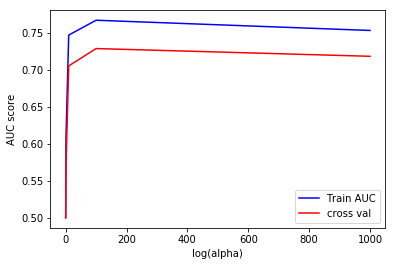

In [235]:
c_values = []
alpha        = 0.0001
while(alpha <= 1000):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = LogisticRegression(penalty='l1', C=C, n_jobs=-1,class_weight = 'balanced')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('log(alpha)')
plt.show()

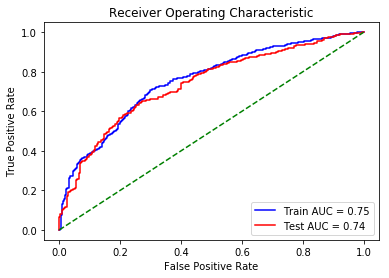

In [236]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [237]:
optimal_model = LogisticRegression(penalty='l2',C=C,class_weight = 'balanced')
optimal_model.fit(X_train, y_train)
prediction = optimal_model.predict(X_test)

In [238]:
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

             precision    recall  f1-score   support

          0       0.32      0.65      0.43       253
          1       0.91      0.72      0.80      1243

avg / total       0.81      0.70      0.74      1496



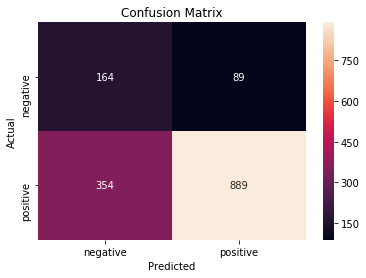

In [239]:
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### L2 reg

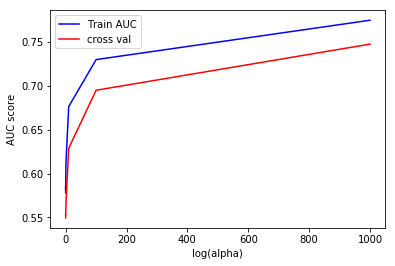

In [240]:
c_values = []
alpha        = 0.0001
while(alpha <= 1000):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = LogisticRegression(penalty='l2', C=C, n_jobs=-1,class_weight = 'balanced')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('log(alpha)')
plt.show()

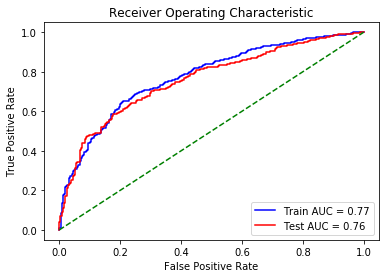

In [241]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [242]:
optimal_model = LogisticRegression(penalty='l2',C=C,class_weight = 'balanced')
optimal_model.fit(X_train, y_train)
prediction = optimal_model.predict(X_test)

In [243]:
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

             precision    recall  f1-score   support

          0       0.32      0.65      0.43       253
          1       0.91      0.72      0.80      1243

avg / total       0.81      0.70      0.74      1496



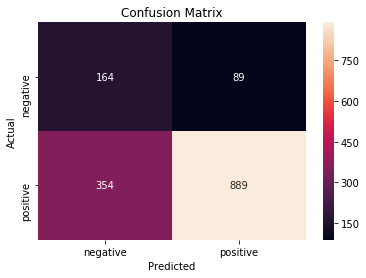

In [244]:
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### [4.4.1.2] TFIDF weighted W2v

In [245]:
# split the data set into train and test
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3)

In [246]:
# Please write all the code with proper documentation
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
model.fit(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

#standardized_weight_w2v = StandardScaler().fit_transform(tfidf_sent_vectors)
#print(standardized_weight_w2v.shape)

def tfidfw2v(test):
    '''
    Returns tfidf word2vec
    '''
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    i=0
    list_of_sentance=[]
    for sentance in test:
        list_of_sentance.append(sentance.split())
        
    for sent in tqdm(list_of_sentance): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
     
    return tfidf_sent_vectors



In [247]:
X_train = tfidfw2v(X_train)
X_cv = tfidfw2v(X_cv)
X_test = tfidfw2v(X_test)

100%|█████████████████████████████████████████████████████████████████████████████| 1496/1496 [00:14<00:00, 102.22it/s]


### L1 reg

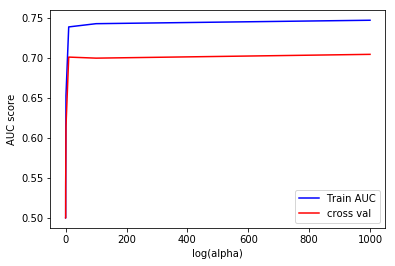

In [248]:
c_values = []
alpha        = 0.0001
while(alpha <= 1000):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = LogisticRegression(penalty='l1', C=C, n_jobs=-1,class_weight = 'balanced')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('log(alpha)')
plt.show()

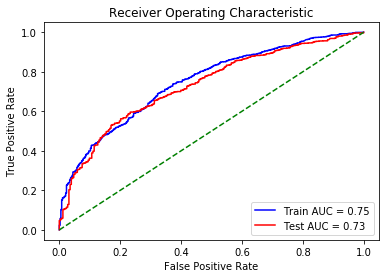

In [249]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [250]:
optimal_model = LogisticRegression(penalty='l2',C=C,class_weight = 'balanced')
optimal_model.fit(X_train, y_train)
prediction = optimal_model.predict(X_test)

In [251]:
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

             precision    recall  f1-score   support

          0       0.32      0.68      0.43       253
          1       0.91      0.70      0.79      1243

avg / total       0.81      0.70      0.73      1496



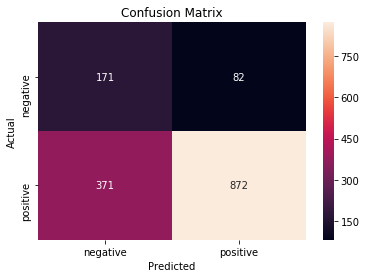

In [252]:
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### L2 reg

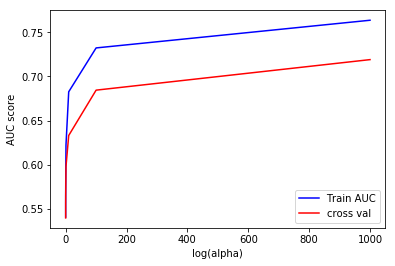

In [253]:
c_values = []
alpha        = 0.0001
while(alpha <= 1000):
    c_values.append(np.round(alpha,4))
    alpha *= 10
    
train_pred = []
cv_pred    = []
for C in c_values:
    model = LogisticRegression(penalty='l2', C=C, n_jobs=-1,class_weight = 'balanced')
    model.fit(X_train, y_train)
    
    #train 
    train_pre = model.predict_proba(X_train)[:,1]
    roc_auc    =  roc_auc_score(y_train, train_pre)
    #np.append(train_pred,roc_auc) 
    train_pred.append(roc_auc)
    
    
    #cross val
    cv_pre    = model.predict_proba(X_cv)[:,1]
    roc_auc2    =  roc_auc_score(y_cv, cv_pre)
    #np.append(cv_pred,roc_auc2)
    cv_pred.append(roc_auc2)

plt.plot(c_values, train_pred, 'b', label = "Train AUC")
plt.plot(c_values, cv_pred, 'r', label = "cross val")

plt.legend()

plt.ylabel('AUC score')
plt.xlabel('log(alpha)')
plt.show()

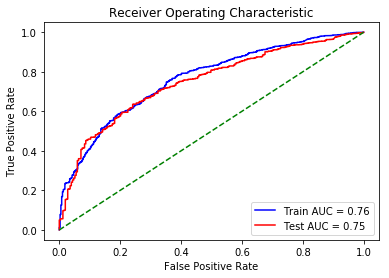

In [254]:
tra_pred = model.predict_proba(X_train)[:,1]
fpr, tpr, thresholds = roc_curve(y_train,tra_pred)
roc_auc = auc(fpr, tpr)

test_pred = model.predict_proba(X_test)[:,1]
fpr2, tpr2, thresholds2 = roc_curve(y_test,test_pred)
roc_auc2 = auc(fpr2, tpr2)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Train AUC = %0.2f'% roc_auc)
plt.plot(fpr2, tpr2, 'r',label='Test AUC = %0.2f'% roc_auc2)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'g--')
#plt.xlim([-0.1,1.2])
#plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [255]:
optimal_model = LogisticRegression(penalty='l2',C=C,class_weight = 'balanced')
optimal_model.fit(X_train, y_train)
prediction = optimal_model.predict(X_test)

In [256]:
print("Classification Report: \n")
print(classification_report(y_test, prediction))

Classification Report: 

             precision    recall  f1-score   support

          0       0.32      0.68      0.43       253
          1       0.91      0.70      0.79      1243

avg / total       0.81      0.70      0.73      1496



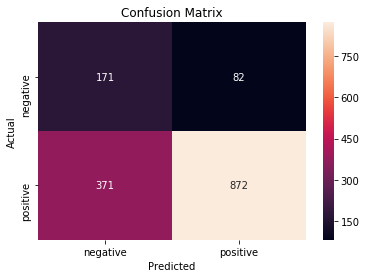

In [257]:
conf_matrix = confusion_matrix(y_test, prediction)
class_label = ['negative', 'positive']
df_conf_matrix = pd.DataFrame(
    conf_matrix, index=class_label, columns=class_label)
sb.heatmap(df_conf_matrix, annot=True, fmt='d')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Conclusion

### L1 regularization

In [258]:
from prettytable import PrettyTable
x1 = PrettyTable()
x1.field_names = ["Type","Model", "AUC"]
x1.add_row(["Bag of Words","LogisticRegression",0.86])
x1.add_row(["TF-IDF","LogisticRegression",0.87])
x1.add_row(["AvgW2V","LogisticRegression",0.74])
x1.add_row(["TfidfAvgW2v","LogisticRegression",0.73])

print(x1)

+--------------+--------------------+------+
|     Type     |       Model        | AUC  |
+--------------+--------------------+------+
| Bag of Words | LogisticRegression | 0.86 |
|    TF-IDF    | LogisticRegression | 0.87 |
|    AvgW2V    | LogisticRegression | 0.74 |
| TfidfAvgW2v  | LogisticRegression | 0.73 |
+--------------+--------------------+------+


### L2 regularization

In [259]:
x2 = PrettyTable()
x2.field_names = ["Type","Model", "AUC"]
x2.add_row(["Bag of Words","LogisticRegression",0.85])
x2.add_row(["TF-IDF","LogisticRegression",0.89])
x2.add_row(["AvgW2V","LogisticRegression",0.76])
x2.add_row(["TfidfAvgW2v","LogisticRegression",0.75])

print(x2)

+--------------+--------------------+------+
|     Type     |       Model        | AUC  |
+--------------+--------------------+------+
| Bag of Words | LogisticRegression | 0.85 |
|    TF-IDF    | LogisticRegression | 0.89 |
|    AvgW2V    | LogisticRegression | 0.76 |
| TfidfAvgW2v  | LogisticRegression | 0.75 |
+--------------+--------------------+------+


### [6] Conclusions
I have considered 120k datapoints.
Both the models Bow and TF-IDF gave the best results.